# Распознавание образов, описываемых гауссовскими случайными векторами с различными матрицами ковариаций

## Задание исходных данных

Даны математические ожидания случайных векторов
$
m_1=
  \begin{bmatrix}
    10 & -2
  \end{bmatrix}
$,
$m_2=
  \begin{bmatrix}
    -4 & 3
  \end{bmatrix}
$,
$m_3=
  \begin{bmatrix}
    1 & -2
  \end{bmatrix}
$  
и матрицы ковариаций:
$$С_1=
  \begin{bmatrix}
    2 & -1\\
    -1 & 3
  \end{bmatrix}
$$

$$С_2=
  \begin{bmatrix}
     5 & 1\\
     1 & 5
  \end{bmatrix}
$$

$$С_3=
  \begin{bmatrix}
     4 & -1\\
    -1 & 4
  \end{bmatrix}
$$

In [1]:
import numpy as np
from scipy.stats import norm
np.set_printoptions(precision=5)
np.set_printoptions(suppress= True)

In [2]:
m = np.matrix([[10,-4,1],[-2,3,-2]])
C1, C2, C3 = np.matrix([[2, -1],[-1, 3]]), np.matrix([[5, 1],[1, 5]]),np.matrix([[4, -1],[-1, 4]])
n = 2 #размерность признакового пространства
M = 3 #число классов
pw = np.array([0.2,0.5,0.3]) #априорные вероятности, заданные произвольно

## Расчет разделяющих функций и вероятностей ошибок разпознавания

In [3]:
C = [C1,C2,C3]
C_= [np.linalg.inv(C1), np.linalg.inv(C2),np.linalg.inv(C3)]

In [4]:
G = np.zeros((M,n+1))
P_err,P_err_,mg,Dg,l0 = np.zeros((M,M)), np.zeros((M,M)),np.zeros((M,M)), np.zeros((M,M)), np.zeros((M,M))

In [5]:
for i in range(M):
    for j in range(i+1,M):
        dmij = m[:,i] - m[:,j]
        l0[i,j] = np.log(pw[j]/pw[i])
        dti = np.linalg.det(C[i])
        dtj = np.linalg.det(C[j])
        trij = np.trace(np.dot(C_[j],C[i]) - np.ones(n))
        trji = np.trace(np.ones(n)-np.dot(C_[i],C[j]))
        
        #математические ожидания и дисперсии гипотез
        mg1 = 0.5*(trij + dmij.T*C_[j]*dmij-np.log(dti/dtj))
        Dg1=0.5*trij**2+dmij.T*C_[j]*C[i]*C_[j]*dmij
        mg2 = 0.5*(trij - dmij.T*C_[i]*dmij+np.log(dtj/dti))
        Dg2=0.5*trij**2+dmij.T*C_[i]*C[j]*C_[i]*dmij
        
        sD1=np.sqrt(Dg1)
        sD2=np.sqrt(Dg2)
        P_err[i,j]=norm.cdf(l0[i,j],mg1,sD1)
        P_err[j,i]=1-norm.cdf(l0[i,j],mg2,sD2);
        mu2=(1/8)*dmij.T*((C[i]/2+C[j]/2)**-1)*dmij+0.5*np.log((dti+dtj)/(2*np.sqrt(dti*dtj)));#расстояние Бхаттачария
        
        P_err_[i,j]=np.sqrt(pw[j]/pw[i])*np.exp(-mu2);
        P_err_[j,i]=np.sqrt(pw[i]/pw[j])*np.exp(-mu2);#границы Чернова
    P_err_[i,i]=1-np.sum(P_err_[i,:])
    P_err[i,i]=1-np.sum(P_err[i,:])#нижняя граница вероятности правильного распознавания

In [6]:
print('Теоретическая матрица вероятностей ошибок: \n',P_err)

Теоретическая матрица вероятностей ошибок: 
 [[ 0.99954  0.00002  0.00044]
 [ 0.00153  0.97392  0.02455]
 [ 0.00974  0.08137  0.9089 ]]


In [7]:
print('Матрица вероятностей ошибок на основе границы Чернова: \n',P_err_)

Матрица вероятностей ошибок на основе границы Чернова: 
 [[ 0.97209  0.00057  0.02734]
 [ 0.00023  0.80925  0.19052]
 [ 0.01823  0.31754  0.66424]]


## Тестирование алгоритма методом статистических испытаний

In [8]:
from numpy.linalg import cholesky
def randncor(n,N,C):
    try:
        A = cholesky(C)
    except LinAlgError:
        m=0
        print('A is not positive definite')
    m = n
    u = np.random.randn(m,N)
    x = A.conj().transpose().dot(u)
    return x 

In [9]:
K = 10000

x = np.matrix(np.ones((n,1)))
u = np.zeros([M,1])
P_err_experiment = np.zeros((M,M))

In [10]:
XK = np.zeros((n, 3 * K))

In [11]:
for k in range(K):
    for i in range(M):
        x_ = randncor(n,1,C[i])
        x[:n,0] = m[:,i] + x_
        XK[:n, (i - 1) * K + k] = x[:n,0].ravel()
        for j in range(M):
            u[j]= -0.5*np.transpose(x-m[:,j])*C_[j]*(x-m[:,j])-0.5*np.linalg.det(C[j])+np.log(pw[j])
        um,umi = u.max(), np.where(u == u.max())[0]
        if i == umi:
            P_err_experiment[i,umi] = P_err_experiment[i,umi]+1
        else:
             P_err_experiment[i,np.abs(P_err_experiment.shape[1]-umi-1)] = P_err_experiment[i,np.abs(P_err_experiment.shape[1]-umi-1)]+1

In [12]:
print('Экспериментальная матрица вероятностей ошибок\n',P_err_experiment/ K)

Экспериментальная матрица вероятностей ошибок
 [[ 1.      0.      0.    ]
 [ 0.3126  0.6871  0.0003]
 [ 0.      0.0036  0.9964]]


## Визуализация областей принятия решений

In [13]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal


matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
fig = plt.figure() 
ax1 = fig.add_subplot(111)

ax1.scatter(XK[0,:K],XK[1,:K], c = 'r')
ax1.scatter(XK[0, K:2*K], XK[1, K:2*K],c= 'g')
ax1.scatter(XK[0, 2*K:3*K], XK[1, 2*K:3*K],c=  'b')
fig.add_subplot(ax1)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

D = 4
if n == 2:
    xmin1 = -4*math.sqrt(D)+ m[0,:].min()
    xmax1 =  4*math.sqrt(D)+ m[0,:].max()
    
    xmin2 = -4*math.sqrt(D)+ m[1,:].min()
    xmax2 =  4*math.sqrt(D)+ m[1,:].max()
    
    step = 0.05
    x1 = np.arange(xmin1,xmax1,step)
    x2 = np.arange(xmin2,xmax2,step)
    
    X1, X2 = np.meshgrid(x1,x2)
    x12=np.column_stack([X1.ravel(),X2.ravel()])
    
    ax = plt.subplot()
    for i in range(M):
        f2 = multivariate_normal.pdf(x12,mean = np.array(m[:,i]).ravel(),cov = C[i])
        f3 = f2.reshape(len(x2),len(x1)).copy()
        CS = ax.contour(x1, x2, f3,[0.01,0.5*max(f3.ravel())])
        ax.clabel(CS, inline=1, fontsize=15)
        for j in range(i+1,M):
            wij = C_[j]*(m[:,i] - m[:,j])
            wij0 = -0.5*np.transpose(m[:,i] +  m[:,j]) *C_[j]*(m[:,i] -  m[:,j])
            f4 = np.transpose(wij) * np.transpose(x12)+wij0
            f5 = f4.reshape(len(x2),len(x1)).copy()
            ax.contour(x1,x2,f5,[l0[i,j]+0.0001])
        fig.add_subplot(ax) 
    

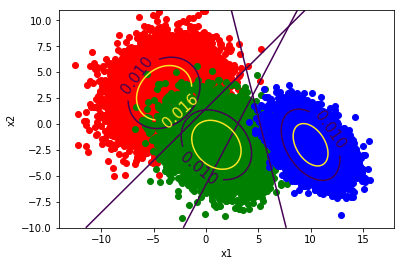

In [14]:
plt.show()

**************